# **Dog breed detector**

## **Import**

In [ ]:
import os
import sys
import numpy as np
import pandas as pd
import cv2
import time
import json
from IPython.core.display import HTML
from matplotlib import pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras import backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import initializers
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback

from tensorflow.keras.applications import ResNet50V2,VGG16, InceptionV3, MobileNetV2, DenseNet121

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import xml.etree.ElementTree as ET 
from PIL import Image 
import tensorflow_datasets as tfds
!pip install tensorflow-addons==0.16.1
import tensorflow_addons as tfa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.8 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.6.0 and strictly below 2.9.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.12.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [ ]:
print("tensorflow version", tf.__version__)
print("keras version", tf.keras.__version__)

tensorflow version 2.12.0
keras version 2.12.0


## **Test GPU + RAM**

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)


from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Mon May 22 09:25:28 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## **Dog DataSet**

In [ ]:
!rm -rf DatasetStore

In [ ]:
import requests
import tarfile
dataset_path = "DatasetStore"

if not os.path.exists(dataset_path):
  os.mkdir(dataset_path)
  packet_url = "http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar"
  packet_file = os.path.basename(packet_url)
  packet_file = os.path.join(dataset_path, packet_file)
  with requests.get(packet_url, stream=True) as r:
      r.raise_for_status()
      with open(packet_file, 'wb') as f:
          for chunk in r.iter_content(chunk_size=8192):
              f.write(chunk)

  with tarfile.open(packet_file) as tfile:
    tfile.extractall(dataset_path)
  
  packet_url = "http://vision.stanford.edu/aditya86/ImageNetDogs/annotation.tar"
  packet_file = os.path.basename(packet_url)
  packet_file = os.path.join(dataset_path, packet_file)
  with requests.get(packet_url, stream=True) as r:
      r.raise_for_status()
      with open(packet_file, 'wb') as f:
          for chunk in r.iter_content(chunk_size=8192):
              f.write(chunk)

  with tarfile.open(packet_file) as tfile:
    tfile.extractall(dataset_path)

**Display some training images**

---



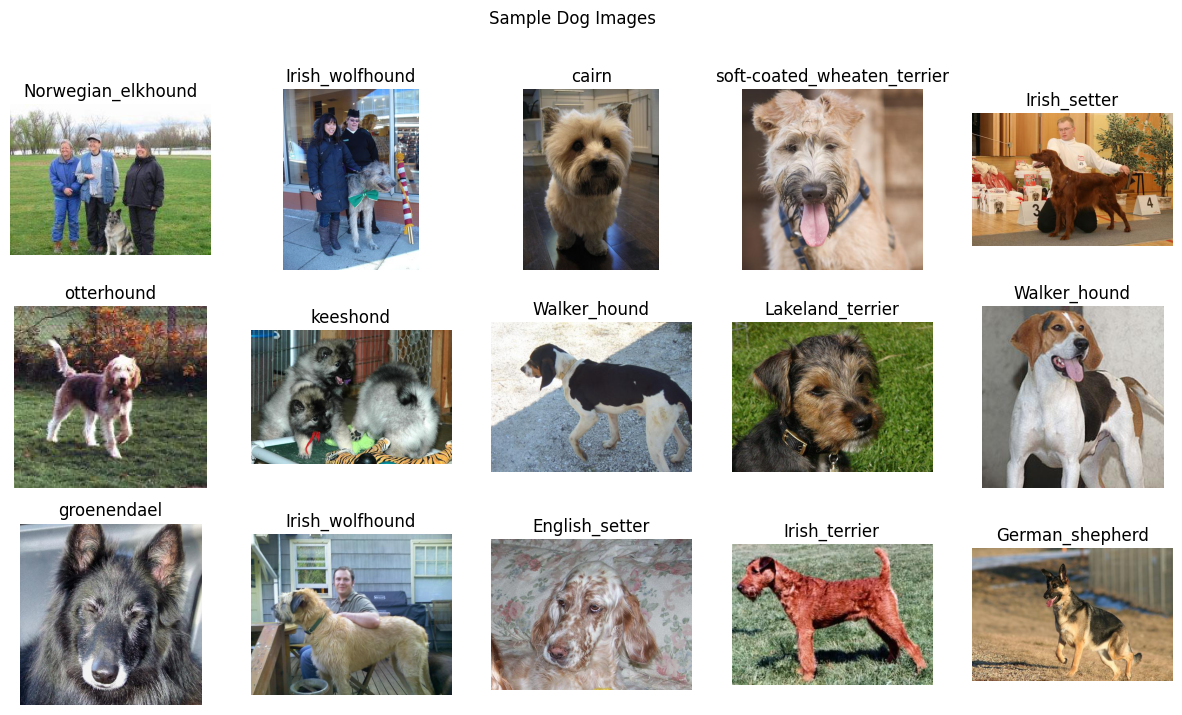

In [ ]:

breed_list = os.listdir('DatasetStore/Annotation/') 

fig = plt.figure(figsize=(15,8))
for i in range(15):
    axs = fig.add_subplot(3,5,i+1)
    breed = np.random.choice(breed_list) 
    dog = np.random.choice(os.listdir('DatasetStore/Annotation/' + breed)) 
    img = Image.open('DatasetStore/Images/' + breed + '/' + dog + '.jpg') 
    tree = ET.parse('DatasetStore/Annotation/' + breed + '/' + dog)
    root = tree.getroot() 
    object_1 = root.findall('object')[0];
    name = object_1.find('name').text;
    axs.set_title(name)
    plt.imshow(img)
    plt.axis('off')

plt.suptitle("Sample Dog Images")
plt.show()

In [ ]:
breed_list = os.listdir('DatasetStore/Annotation/'); 
breed_list.sort()
for i,breed in enumerate(breed_list):
  breed_list[i] = breed[10:];

label2index = dict((name, index) for index, name in enumerate(breed_list))
index2label = dict((index, name) for index, name in enumerate(breed_list))
print(breed_list[:3])

['Chihuahua', 'Japanese_spaniel', 'Maltese_dog']


**Load data**

In [ ]:
breed_list = os.listdir('DatasetStore/Annotation/') 
breed_list.sort()

label2index = dict((name, index) for index, name in enumerate(breed_list))
index2label = dict((index, name) for index, name in enumerate(breed_list))

images = []
annotations =[]
for breed in breed_list:
  image_files = os.listdir('DatasetStore/Images/' + breed)
  image_files.sort()
  images.extend([os.path.join('DatasetStore/Images/',breed,f) for f in image_files])
  annotations.extend([os.path.join('DatasetStore/Annotation/',breed,f.replace(".jpg","")) for f in image_files])

for idx, ann in enumerate(annotations):
    annotations[idx] = ann.split("/")[2]

Xs = np.asarray(images)
Ys = np.asarray(annotations)

print('Xs shape',Xs.shape)
print(Xs[:5])
print('Ys shape',Ys.shape)
print(Ys[:5])

train_validate_x,test_x, train_validate_y, test_y = train_test_split(Xs,Ys,test_size=0.1)

print("train_validate_x shape:",train_validate_x.shape)
print('train_validate_x[:5]:',train_validate_x[:5])
print("train_validate_y shape:",train_validate_y.shape)
print('train_validate_y[:5]:',train_validate_y[:5])

print("test_x shape:",test_x.shape)
print('test_x[:5]:',test_x[:5])
print("test_y shape:",test_y.shape)
print('test_y[:5]:',test_y[:5])

Xs shape (20580,)
['DatasetStore/Images/n02085620-Chihuahua/n02085620_10074.jpg'
 'DatasetStore/Images/n02085620-Chihuahua/n02085620_10131.jpg'
 'DatasetStore/Images/n02085620-Chihuahua/n02085620_10621.jpg'
 'DatasetStore/Images/n02085620-Chihuahua/n02085620_1073.jpg'
 'DatasetStore/Images/n02085620-Chihuahua/n02085620_10976.jpg']
Ys shape (20580,)
['n02085620-Chihuahua' 'n02085620-Chihuahua' 'n02085620-Chihuahua'
 'n02085620-Chihuahua' 'n02085620-Chihuahua']
train_validate_x shape: (18522,)
train_validate_x[:5]: ['DatasetStore/Images/n02085936-Maltese_dog/n02085936_20076.jpg'
 'DatasetStore/Images/n02097047-miniature_schnauzer/n02097047_2917.jpg'
 'DatasetStore/Images/n02089078-black-and-tan_coonhound/n02089078_376.jpg'
 'DatasetStore/Images/n02088364-beagle/n02088364_2652.jpg'
 'DatasetStore/Images/n02112350-keeshond/n02112350_8077.jpg']
train_validate_y shape: (18522,)
train_validate_y[:5]: ['n02085936-Maltese_dog' 'n02097047-miniature_schnauzer'
 'n02089078-black-and-tan_coonhound'

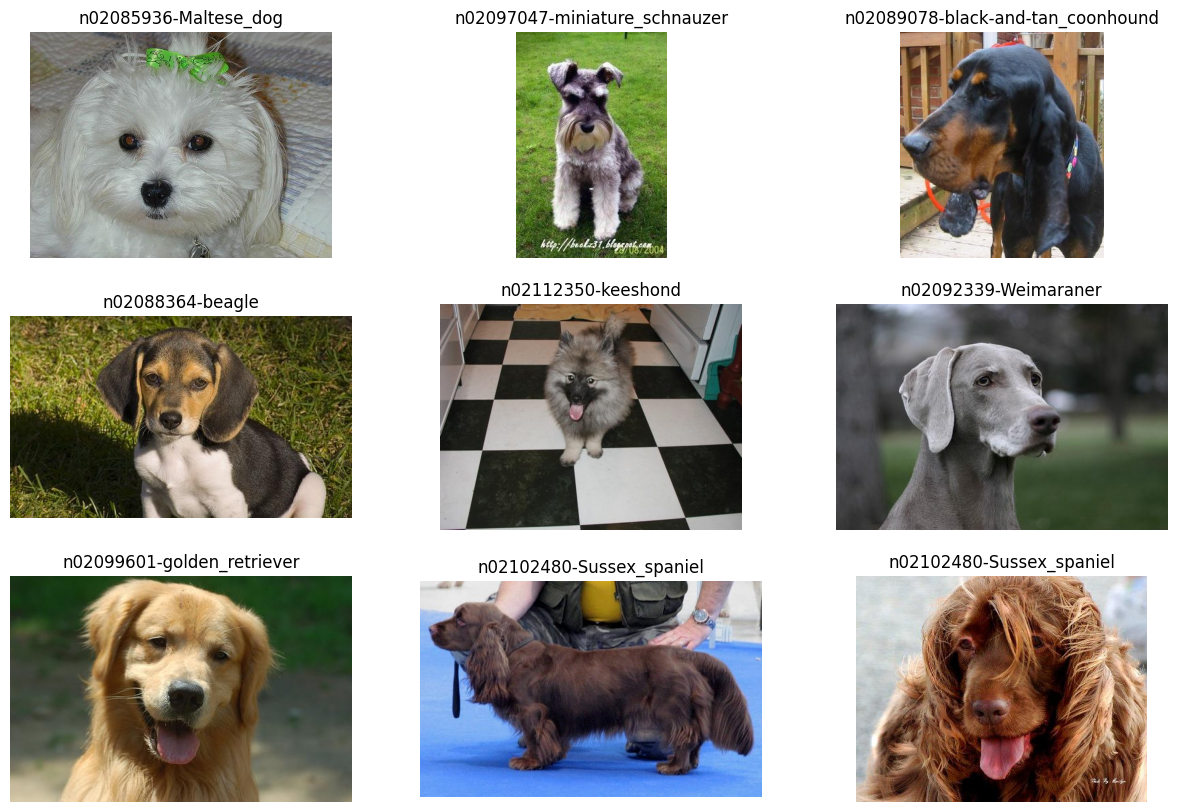

In [ ]:
fig = plt.figure(figsize=(15,10))

for idx in range(9):
  sample_input = cv2.imread(train_validate_x[idx])
  sample_input = cv2.cvtColor(sample_input, cv2.COLOR_BGR2RGB)
  breed = train_validate_y[idx];
  axs = fig.add_subplot(3,3,idx+1)
  axs.set_title(breed)
  plt.imshow(sample_input)
  plt.axis('off')

plt.show();



## **Build Data Generator**

In [ ]:
validation_percent = 0.2
image_width = 128
image_height = 128
num_channels = 3
num_classes = len(breed_list);

epochs = 30
train_batch_size = 32
validation_batch_size = 32
test_batch_size = 32
train_shuffle_size = train_batch_size * 3
validation_shuffle_size = validation_batch_size * 3

train_x, validate_x, train_y, validate_y = train_test_split(train_validate_x, train_validate_y, test_size=validation_percent) 

train_processed_y = np.asarray([label2index[label] for label in train_y])
validate_processed_y = np.asarray([label2index[label] for label in validate_y])
test_processed_y = np.asarray([label2index[label] for label in test_y])
train_processed_y = to_categorical(train_processed_y, num_classes=num_classes, dtype='float32')
validate_processed_y = to_categorical(validate_processed_y, num_classes=num_classes, dtype='float32')
test_processed_y = to_categorical(test_processed_y, num_classes=num_classes, dtype='float32')

train_data_count = train_x.shape[0]
steps_per_epoch = np.int(train_data_count / train_batch_size)
validation_data_count = validate_x.shape[0]
validation_steps = np.int(validation_data_count / validation_batch_size)

def load_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=num_channels)
    image = tf.image.resize(image,[image_height,image_width])
    return image, label

def normalize(image, label):
    image = image/255
    return image, label 

def build_data_generators(train_data_process_list=[load_image,normalize],validate_data_process_list=[load_image,normalize],test_data_process_list=[load_image,normalize]):

    train_data = tf.data.Dataset.from_tensor_slices((train_x.tolist(), train_processed_y.tolist()))
    validation_data = tf.data.Dataset.from_tensor_slices((validate_x.tolist(), validate_processed_y.tolist()))
    test_data = tf.data.Dataset.from_tensor_slices((test_x.tolist(), test_processed_y.tolist()))


    # Train data
    train_data = train_data.shuffle(train_data_count)
    for process in train_data_process_list:
        train_data = train_data.map(process, num_parallel_calls=AUTOTUNE)
    
    train_data = train_data.repeat(epochs).batch(train_batch_size)

    # Validation data
    validation_data = validation_data.shuffle(validation_data_count)
    for process in validate_data_process_list:
        validation_data = validation_data.map(process, num_parallel_calls=AUTOTUNE)
    
    validation_data = validation_data.repeat(epochs).batch(validation_batch_size)

    # Test data
    for process in test_data_process_list:
        test_data = test_data.map(process, num_parallel_calls=AUTOTUNE)
    test_data = test_data.repeat(1).batch(test_batch_size)
    
    return train_data, validation_data, test_data

train_data, validation_data, test_data = build_data_generators()
print("train_data",train_data)
print("validation_data",validation_data)
print("test_data",test_data)

<ipython-input-12-14ba494b836a>:24: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  steps_per_epoch = np.int(train_data_count / train_batch_size)
<ipython-input-12-14ba494b836a>:26: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
De

train_data <_BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.float32, name=None))>
validation_data <_BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.float32, name=None))>
test_data <_BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.float32, name=None))>


## **Utility Function**

In [ ]:


class JsonEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, decimal.Decimal):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(JsonEncoder, self).default(obj)
        
def get_model_metrics():
    with open("./SavedModels/model_metrics.json") as json_file:
        model_metrics = json.load(json_file)
    
    return model_metrics

def save_model_metrics(model_name="model_1",metrics={}):
    if os.path.exists("./SavedModels/model_metrics.json"):
        with open("./SavedModels/model_metrics.json") as json_file:
            model_metrics = json.load(json_file)
    else:
        model_metrics = {}
    
    model_metrics[model_name] = metrics
    
    with open("./SavedModels/model_metrics.json", 'w') as json_file:
        json_file.write(json.dumps(model_metrics, cls=JsonEncoder))
        
def save_model(path="./SavedModels",model_name="model01"):
    filename = "./SavedModels/"
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    model.save(os.path.join(path,model_name+".hdf5"))

    model.save_weights(os.path.join(path,model_name+".h5"))

    model_json = model.to_json()
    with open(os.path.join(path,model_name+".json"), "w") as json_file:
        json_file.write(model_json)

def get_model_size(path="./SavedModels",model_name="model01"):
    model_size = os.stat(os.path.join(path,model_name+".hdf5")).st_size
    return model_size

def evaluate_save_model(model,training_results,test_data,execution_time, learning_rate, batch_size, epochs, optimizer,momentum = None, save=True):
    
    model_train_history = training_results.history
    num_epochs = len(model_train_history["loss"])

    fig = plt.figure(figsize=(15,5))
    axs = fig.add_subplot(1,2,1)
    axs.set_title('Loss')
    for metric in ["loss","val_loss"]:
        axs.plot(np.arange(0, num_epochs), model_train_history[metric], label=metric)
    axs.legend()
    
    axs = fig.add_subplot(1,2,2)
    axs.set_title('Accuracy')
    for metric in ["accuracy","val_accuracy"]:
        axs.plot(np.arange(0, num_epochs), model_train_history[metric], label=metric)
    axs.legend()

    plt.show()
    
    evaluation_results = model.evaluate(test_data)
    print('Evaluation results: [loss, accuracy]', evaluation_results)
    
    if save:
        save_model(model_name=model.name)
        model_size = get_model_size(model_name=model.name)

        with open(os.path.join("./SavedModels",model.name+"_train_history.json"), "w") as json_file:
            json_file.write(json.dumps(model_train_history,cls=JsonEncoder))

        trainable_parameters = model.count_params()

        metrics ={
            "trainable_parameters":trainable_parameters,
            "execution_time":execution_time,
            "loss":evaluation_results[0],
            "accuracy":evaluation_results[1],
            "model_size":model_size,
            "learning_rate":learning_rate,
            "batch_size":batch_size,
            'momentum': momentum,
            "epochs":epochs,
            "optimizer":type(optimizer).__name__
        }
        save_model_metrics(model_name=model.name,metrics=metrics)

Compare all models

## **VGG16**
Use VGG16 as the base and fine tune the last conv2d block for our problem

### Build model

In [ ]:
vgg16 = VGG16(include_top=False, weights='imagenet', input_shape=(image_height,image_width,3))

def view_layers(model):
    layers = model.layers
    layers_list = []
    
    for idx, layer in enumerate(layers):
        layers_list.append({
            'layer': type(layer).__name__,
        })
    
    df = pd.DataFrame(layers_list)
    
    return df

layers_df = view_layers(vgg16)
# print(layers_df[0:])

58889256/58889256 [==============================] - 0s 0us/step


### Training params

In [ ]:
learning_rate = 0.001
batch_size = 32
epochs = 50

for layer in vgg16.layers[:-4]:
    layer.trainable = False

model_input = vgg16.layers[0].input

hidden = vgg16.layers[-1]
print("Pool Layer",hidden)

hidden = layers.Flatten()(hidden.output)

hidden = layers.Dense(units=1024, activation='relu')(hidden)
hidden = layers.Dense(units=1024, activation='relu')(hidden)

output = layers.Dense(units=num_classes, activation='softmax')(hidden)

model = Model(model_input, output, name='VGG16')

optimizer = optimizers.SGD(lr=learning_rate)

loss = losses.categorical_crossentropy

model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=['accuracy'])

#print(model.summary())
layers_df = view_layers(model)
print(layers_df.head(25))



Pool Layer <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7fa9e15f1ab0>
           layer
0     InputLayer
1         Conv2D
2         Conv2D
3   MaxPooling2D
4         Conv2D
5         Conv2D
6   MaxPooling2D
7         Conv2D
8         Conv2D
9         Conv2D
10  MaxPooling2D
11        Conv2D
12        Conv2D
13        Conv2D
14  MaxPooling2D
15        Conv2D
16        Conv2D
17        Conv2D
18  MaxPooling2D
19       Flatten
20         Dense
21         Dense
22         Dense


### Train model

In [ ]:

earlystopping = EarlyStopping(monitor='val_accuracy', patience=10);

checkpoint_filepath = './Checkpoints/checkpoint_VGG16'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    verbose=1,
    mode='max',
    save_best_only=True)


start_time = time.time()
training_results = model.fit(
        train_data,
        validation_data=validation_data,
        callbacks=[earlystopping,model_checkpoint_callback],
        epochs=epochs, 
        verbose=1,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)


Epoch 1/50
463/463 [==============================] - ETA: 0s - loss: 4.3961 - accuracy: 0.0549
Epoch 1: val_accuracy improved from -inf to 0.11005, saving model to ./Checkpoints/checkpoint_VGG16
463/463 [==============================] - 45s 70ms/step - loss: 4.3961 - accuracy: 0.0549 - val_loss: 3.7208 - val_accuracy: 0.1101
Epoch 2/50
463/463 [==============================] - ETA: 0s - loss: 3.2749 - accuracy: 0.2017
Epoch 2: val_accuracy improved from 0.11005 to 0.21223, saving model to ./Checkpoints/checkpoint_VGG16
463/463 [==============================] - 32s 68ms/step - loss: 3.2749 - accuracy: 0.2017 - val_loss: 3.1365 - val_accuracy: 0.2122
Epoch 3/50
463/463 [==============================] - ETA: 0s - loss: 2.5900 - accuracy: 0.3317
Epoch 3: val_accuracy improved from 0.21223 to 0.27772, saving model to ./Checkpoints/checkpoint_VGG16
463/463 [==============================] - 31s 67ms/step - loss: 2.5900 - accuracy: 0.3317 - val_loss: 2.8260 - val_accuracy: 0.2777
Epoch 4

### Evaluate and Save

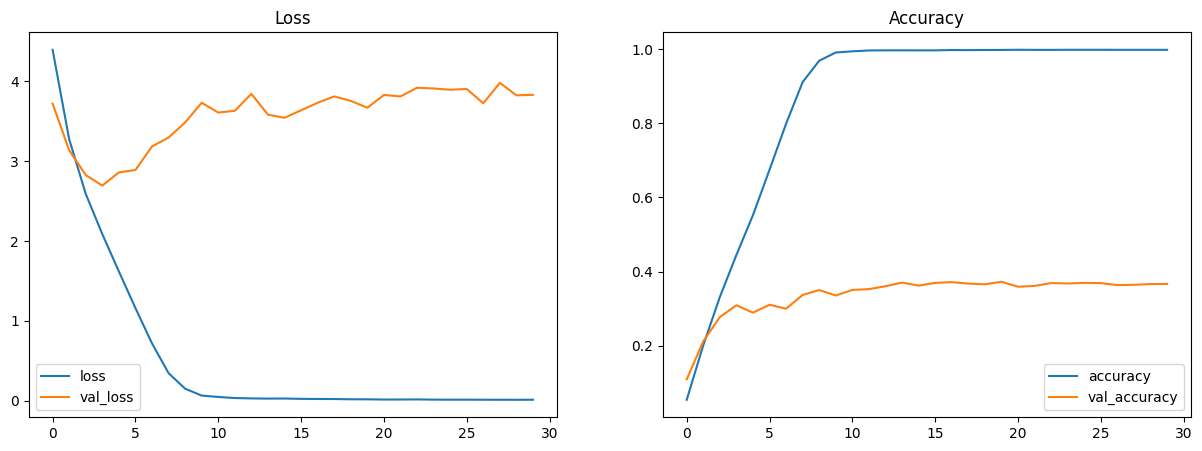

65/65 [==============================] - 5s 83ms/step - loss: 3.9206 - accuracy: 0.3698
Evaluation results: [loss, accuracy] [3.9206457138061523, 0.36977648735046387]


In [ ]:
evaluate_save_model(model,training_results,test_data,execution_time, learning_rate, batch_size, epochs, optimizer)